# Homework 8 - Descriptive Notebook

In this homework notebook, we will create an iterative and targeted gradient attack, to be used on a model trained on the CIFAR10 dataset.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before March 28th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Wilbert Aristo Guntoro
# Student ID: 1003742

### Imports needed

In [2]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# Torchvision
from torchvision import datasets, transforms
# Our custom ResNet
from resnet import *

### Testing for CUDA

We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Dataset and Dataloader

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.
The test set has 1000 images in each class, but for simplicity and reduced execution time, we will only use 20 images in each class to evaluate our attack functions.

In [4]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the CIFAR10 dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

In [5]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])

In [6]:
# CIFAR10 dataset and dataloader
# (For testing only, we will use a pre-trained model)
test_dataset = torchvision.datasets.CIFAR10(root = './data/', train = False, transform = tf)
test_dataset_reduced = torch.utils.data.Subset(test_dataset, [i for i in range(0, 200)])
test_loader = torch.utils.data.DataLoader(dataset = test_dataset_reduced, batch_size = 1, shuffle = False)
print(len(test_loader))

200


### Model

We will use a simple pre-trained resnet model, with architecture and trainer stored in resnet.py and weights stored in file resnet.data.
This is a pre-trained model with a simple architecture. Its baseline accuracy is 88.16%, and a rather easy target for an attack.

In [7]:
# Load the pretrained model
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
pretrained_model = "./resnet.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### Your task

Write a function iugm_attack(), which performs an untargeted iterated gradient attack.
- It should use the Option #2, described in class, which is aiming towards the least probable class, according to the logits.
- It should have a maximal number of iterations, set to 10 by default.
- It has 4 inputs: our original image, the epsilon value to be used, the model under attack, the original label for the image and a maximal number of iterations for the attack.
- Our attack function simply returns the attack sample to be evaluated by our test function.

In [8]:
def iugm_attack(image, epsilon, model, original_label, iter_num = 10):
    # Init eps_image
    eps_image = None
    
    # Get Least Probable Class
    output = model(image)
    _, least_probable_label = torch.min(output.data, 1)
    
    # Start iterating attack
    for i in range(iter_num):
        # Get output of current image
        output = model(image)
        
        # Get the loss of Least Probable Class
        loss = F.nll_loss(output, least_probable_label)
        
        # Get the gradient of this loss
        loss.backward(retain_graph = True)
        
        # Move towards the least probable class
        eps_image = image - epsilon * image.grad.data
        
        # Clipping eps_image to maintain pixel 
        # values into the [0, 1] range
        eps_image = torch.clamp(eps_image, 0, 1)
        
        # Get new prediction
        new_output = model(eps_image)
        _, new_pred = torch.max(new_output.data, 1)
        
        # If the model misclassified the image then stop
        # Else, continue iterating the eps_image
        if new_pred.item() != original_label.item():
            break
        else:
            image = eps_image
            image.retain_grad()
    return eps_image

### Testing your attack on your model

Below is our testing function, same as usual.

In [9]:
def test(model, device, test_loader, epsilon, max_iter = 10):

    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for image, label in test_loader:
        
        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the ugm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        _, init_pred = torch.max(output.data, 1)

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue
            
        # Call IUGM Attack
        eps_image = iugm_attack(image, epsilon, model, label, max_iter)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        _, eps_pred = torch.max(output2.data, 1)

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if eps_pred.item() == label.item():
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Model Accuracy (under attack) = {}/{} = {}".format(epsilon, \
                                                                            correct_counter, \
                                                                            len(test_loader), \
                                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

### Visualization 

As usual, we will display the accuracy vs. epsilon values graph for our given attack, as well as some samples for the given epsilon values.
We will consider two different attack strategies (alpha and beta), with different epsilon values and numbers of maximal iterations 

#### Alpha attack: one-shot untargeted gradient attack

We fix max_iter = 1, which make our iterated attack a one-shot attack.

#### Beta attack: iterated untargeted gradient attack

We fix max_iter = 20.

In [10]:
# Part 1.A
epsilons = [0, .005, .01, .02, .05,  .1, .2, .5, 1]
accuracies = []
examples = []
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, max_iter = 1)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.005 - Model Accuracy (under attack) = 144/200 = 0.72
Epsilon: 0.01 - Model Accuracy (under attack) = 117/200 = 0.585
Epsilon: 0.02 - Model Accuracy (under attack) = 89/200 = 0.445
Epsilon: 0.05 - Model Accuracy (under attack) = 62/200 = 0.31
Epsilon: 0.1 - Model Accuracy (under attack) = 28/200 = 0.14
Epsilon: 0.2 - Model Accuracy (under attack) = 21/200 = 0.105
Epsilon: 0.5 - Model Accuracy (under attack) = 17/200 = 0.085
Epsilon: 1 - Model Accuracy (under attack) = 19/200 = 0.095


In [11]:
# Part 1.B
epsilons2 = [0, .001, .002, .005, .01,  .02, .05, .1, .2, .5]
accuracies2 = []
examples2 = []
for eps in epsilons2:
    acc, ex = test(model, device, test_loader, eps, max_iter = 20)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.001 - Model Accuracy (under attack) = 5/200 = 0.025
Epsilon: 0.002 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.005 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.01 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.02 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.05 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.1 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.2 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.5 - Model Accuracy (under attack) = 0/200 = 0.0


The graph below will display the accuracy vs. epsilon value for both attacks (1.A and 1.B).

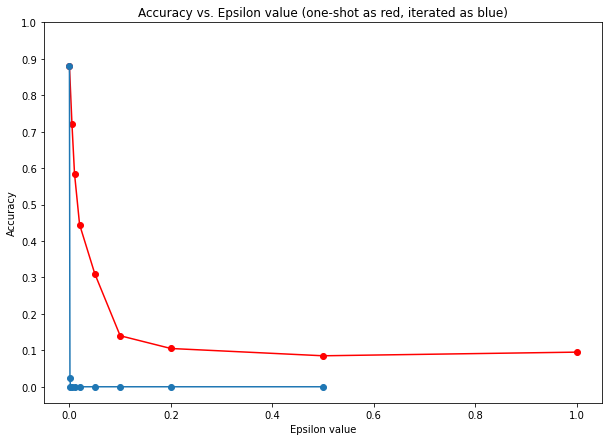

In [12]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-", color = "red")
plt.plot(epsilons2, accuracies2, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title("Accuracy vs. Epsilon value (one-shot as red, iterated as blue)")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

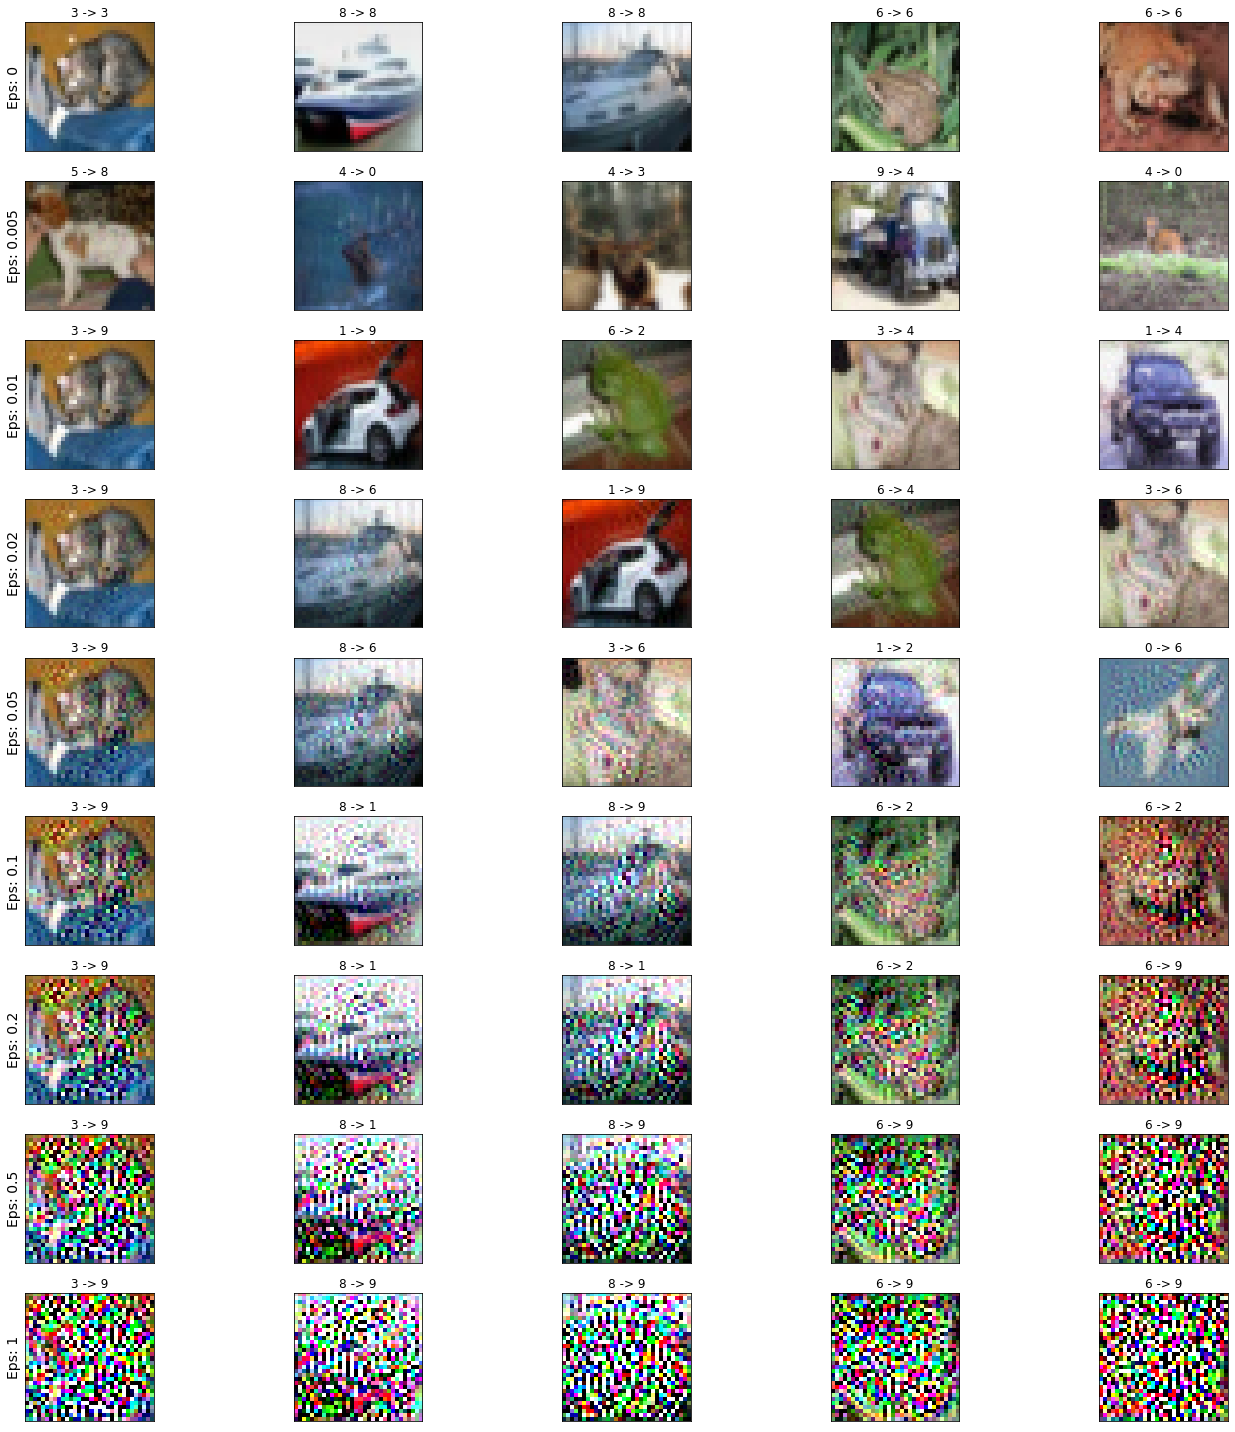

In [13]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (20, 20))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    # If example list does not contain 5 samples for this epsilon,
    # do not display this epsilon value
    if len(examples[i]) != 5:
        continue
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Reshape ex for imshow
        ex = np.transpose(ex, (1, 2, 0))
        
        # Display image
        plt.imshow(ex)
        
# Display full plot
plt.tight_layout()
plt.show()

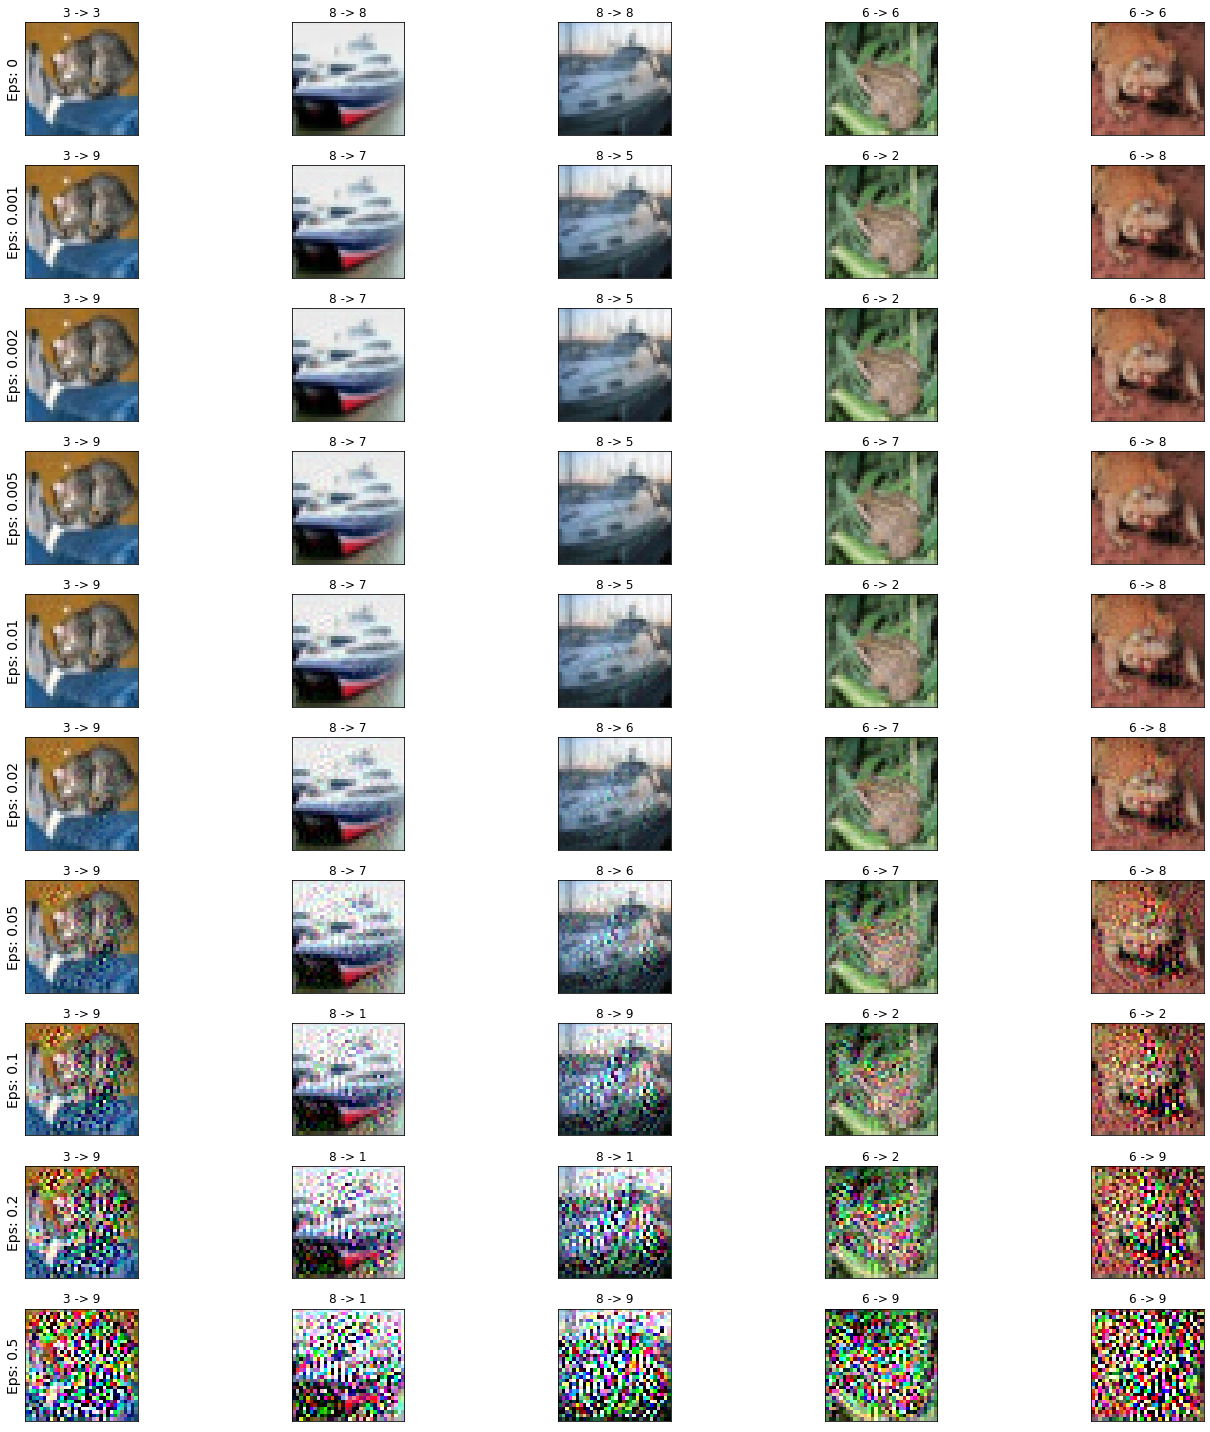

In [14]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (20, 20))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons2)):
    # If example list does not contain 5 samples for this epsilon,
    # do not display this epsilon value
    if len(examples2[i]) != 5:
        continue
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons2), len(examples2[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons2[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Reshape ex for imshow
        ex = np.transpose(ex, (1, 2, 0))
        
        # Display image
        plt.imshow(ex)
        
# Display full plot
plt.tight_layout()
plt.show()

### Questions and expected answers for the report

A. Copy and paste the code for your iugm_attack() function.

B. What do you observe on the accuracy vs. epsilon graph. Why are the two curves different? Is that something to be expected?

C. What seems to be the threshold for plausibility for both attacks (alpha and beta)? Is attack beta a better one? Why?

D. Plausibility seems problematic, even with the iterated version of the gradient attack. Can you suggest two possible ways to improve our attack strategy on this dataset and model?